#### <h1><center>CSE 676-B: Deep Learning</center></h1>
### <center>Prof. Alina Vereshchaka</center>
### <center>Spring 2024</center>

<center>
<h2>Autoencoder and Transformer Architectures</h2>
<h3>Team:

Charvi Kusuma, charviku@buffalo.edu

Tarun Reddi, bhanucha@buffalo.edu</h3>
<h1 style="color: blue">Assignment 2</h1>
<span style="color: red">

Checkpoint: April 2, Tue, 11:59 pm

Due date: April 11, Thu 11:59pm

</span>
<center>


In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Part II: Autoencoders for Anomaly Detection [30 points]

### Data Loading and Cleaning

In [2]:
df = pd.read_csv("D:\\Documents\\Studies\\MS\\UB\\MY Masters\\SPR SEM 2024\\Deep Learning\\Assignments\\2\\Twitter_volume_AAPL.csv")

In [3]:
df.shape

(15902, 2)

In [4]:
df.head()

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120


In [5]:
df.dtypes

timestamp    object
value         int64
dtype: object

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df.dtypes

timestamp    datetime64[ns]
value                 int64
dtype: object

In [8]:
df.describe()

,timestamp,value
count,15902,15902.000000
mean,2015-03-26 12:15:22.999999744,85.552320
min,2015-02-26 21:42:53,0.000000
25%,2015-03-12 16:59:08,29.000000
50%,2015-03-26 12:15:23,47.000000
75%,2015-04-09 07:31:38,76.000000
max,2015-04-23 02:47:53,13479.000000
std,NaN,321.050721


In [9]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

### Vizualizations

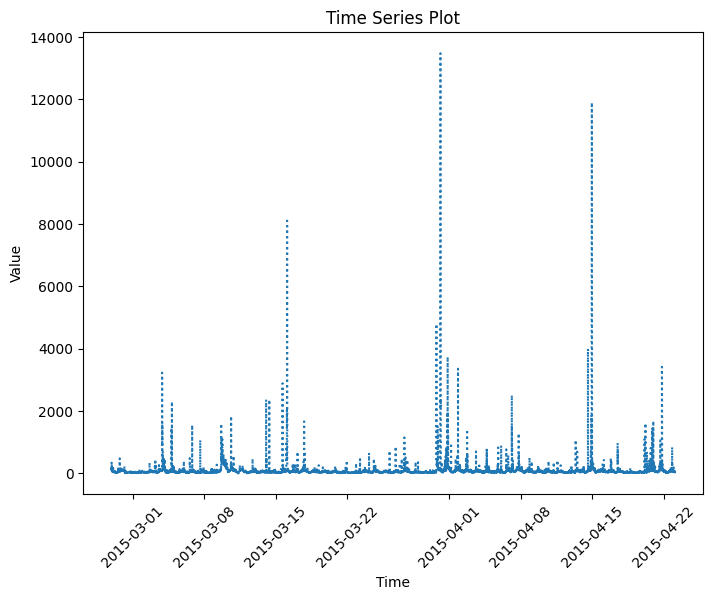

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(df['timestamp'], df['value'], linestyle = 'dotted')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

In [11]:
data = df

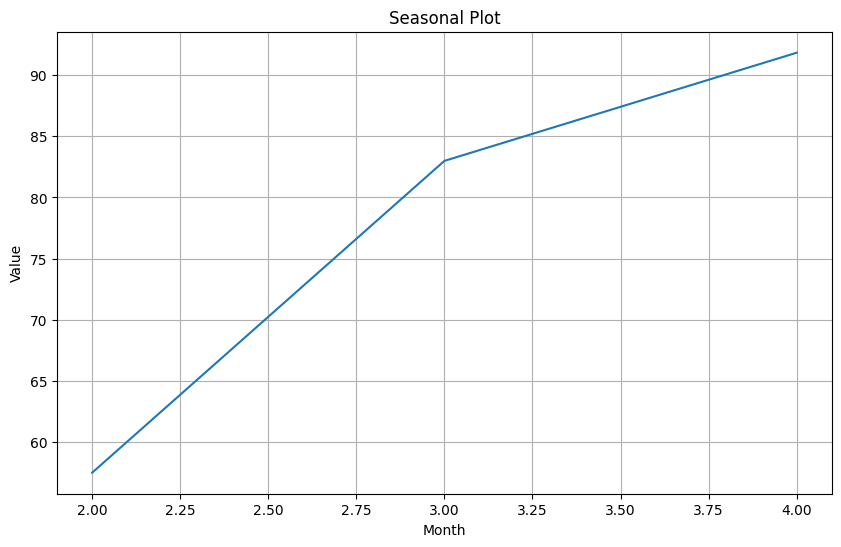

In [12]:
data['month'] = data['timestamp'].dt.month
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='value', data=data, errorbar=None)
plt.title('Seasonal Plot')
plt.xlabel('Month')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [13]:
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour

In [14]:
data.head()

,timestamp,value,month,day,hour
0,2015-02-26 21:42:53,104,2,26,21
1,2015-02-26 21:47:53,100,2,26,21
2,2015-02-26 21:52:53,99,2,26,21
3,2015-02-26 21:57:53,154,2,26,21
4,2015-02-26 22:02:53,120,2,26,22


In [15]:
data['day_of_year'] = data['timestamp'].dt.dayofyear
data['radians'] = np.deg2rad(data['day_of_year'] / 365 * 360)

In [16]:
daily_data = data.groupby('day_of_year')['value'].mean().reset_index()
daily_data['radians'] = np.deg2rad(daily_data['day_of_year'] / 365 * 360)

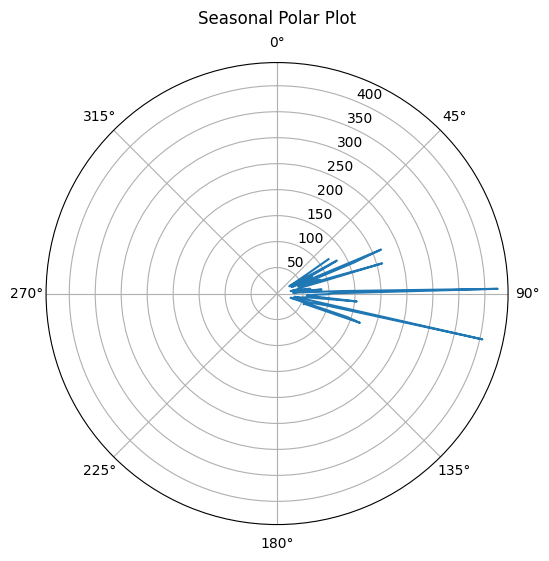

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 6))
ax.plot(daily_data['radians'], daily_data['value'])
ax.set_theta_zero_location('N')  
ax.set_theta_direction(-1) 
ax.set_title('Seasonal Polar Plot', va='bottom')
ax.grid(True)
plt.show()

### Data Scaling and Splitting

In [18]:
scaler = MinMaxScaler()
value_column = df['value'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(value_column)
df['value'] = scaled_values

In [19]:
df.head()

,timestamp,value,month,day,hour,day_of_year,radians
0,2015-02-26 21:42:53,0.007716,2,26,21,57,0.98121
1,2015-02-26 21:47:53,0.007419,2,26,21,57,0.98121
2,2015-02-26 21:52:53,0.007345,2,26,21,57,0.98121
3,2015-02-26 21:57:53,0.011425,2,26,21,57,0.98121
4,2015-02-26 22:02:53,0.008903,2,26,22,57,0.98121


In [20]:
df.shape

(15902, 7)

In [21]:
df.dtypes

timestamp      datetime64[ns]
value                 float64
month                   int32
day                     int32
hour                    int32
day_of_year             int32
radians               float64
dtype: object

In [22]:
df = df[['timestamp', 'value']]

In [23]:
train, test_val = train_test_split(df, test_size=0.3, shuffle=False)

In [24]:
test, val = train_test_split(test_val, test_size=0.5, shuffle=False)

In [25]:
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Train set size: 11131
Validation set size: 2386
Test set size: 2385


In [26]:
train.shape

(11131, 2)

In [27]:
val.shape

(2386, 2)

In [28]:
test.shape

(2385, 2)

In [29]:
sequence_size = 16

In [30]:
def gen_sq(X, y, time_steps = sequence_size):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])

    return np.array(Xs), np.array(ys)

In [31]:
X_train, y_train = gen_sq(train[['value']], train['value'])
X_test, y_test = gen_sq(test[['value']], test['value'])
X_val, y_val = gen_sq(val[['value']], val['value'])

In [32]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11115, 16, 1)
(2369, 16, 1)
(2370, 16, 1)


In [33]:
input_shape = (sequence_size, 1)

### Base Model

In [34]:
encoder_inputs = tf.keras.Input(shape=input_shape)
encoder = layers.Flatten()(encoder_inputs)
encoder = layers.Dense(8, activation='relu')(encoder)
encoded = layers.Dense(2, activation='relu')(encoder)
decoder = layers.Dense(4, activation='relu')(encoded)
decoder = layers.Dense(8, activation='relu')(decoder)
decoder = layers.Dense(np.prod(input_shape), activation='sigmoid')(decoder)
decoded = layers.Reshape(input_shape)(decoder)
autoencoder_base = models.Model(encoder_inputs, decoded, name='autoencoder_base')

In [35]:
autoencoder_base.compile(optimizer='adam', loss='mse')
autoencoder_base.summary()

Model: "autoencoder_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 16)           

In [36]:
history = autoencoder_base.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
348/348 [==============================] - 6s 6ms/step - loss: 0.1025 - val_loss: 0.0035
Epoch 2/10
348/348 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 3/10
110/348 [========>.....................] - ETA: 1s - loss: 6.3987e-04

348/348 [==============================] - 2s 6ms/step - loss: 5.4806e-04 - val_loss: 0.0017
Epoch 4/10
348/348 [==============================] - 2s 5ms/step - loss: 4.7720e-04 - val_loss: 0.0017
Epoch 5/10
348/348 [==============================] - 2s 5ms/step - loss: 4.5703e-04 - val_loss: 0.0017
Epoch 6/10
348/348 [==============================] - 2s 7ms/step - loss: 4.4952e-04 - val_loss: 0.0017
Epoch 7/10
348/348 [==============================] - 2s 7ms/step - loss: 4.4647e-04 - val_loss: 0.0017
Epoch 8/10
348/348 [==============================] - 2s 6ms/step - loss: 4.4487e-04 - val_loss: 0.0017
Epoch 9/10
348/348 [==============================] - 2s 6ms/step - loss: 4.4425e-04 - val_loss: 0.0017
Epoch 10/10
348/348 [==============================] - 3s 8ms/step - loss: 4.4380e-04 - val_loss: 0.0017


In [37]:
print("Training Loss Autoencoder Base:", history.history['loss'])
print("Validation Loss Autoencoder Base:", history.history['val_loss'])

Training Loss Autoencoder Base: [0.10246467590332031, 0.0010865526273846626, 0.0005480586551129818, 0.00047720386646687984, 0.00045703063369728625, 0.0004495180619414896, 0.0004464733647182584, 0.0004448683175724, 0.00044425061787478626, 0.0004438030009623617]
Validation Loss Autoencoder Base: [0.0034997554030269384, 0.0018454797100275755, 0.0017239991575479507, 0.001695364131592214, 0.001686273841187358, 0.0016826798673719168, 0.001681350520811975, 0.0016807212959975004, 0.0016804514452815056, 0.001680168672464788]


In [38]:
test_loss = autoencoder_base.evaluate(X_test, y_test)
print("Test Loss Autoencoder Base:", test_loss)

75/75 [==============================] - 0s 4ms/step - loss: 1.0658e-04
Test Loss Autoencoder Base: 0.00010658394603524357


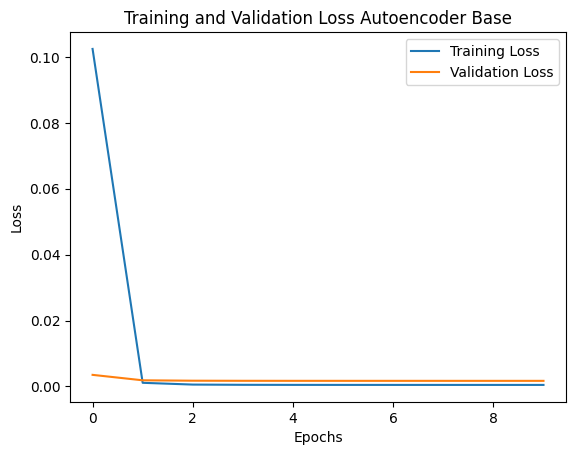

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Autoencoder Base')
plt.legend()
plt.show()


In [40]:
X_train_pred = autoencoder_base.predict(X_train, verbose=0)
X_test_pred = autoencoder_base.predict(X_test, verbose=0)

In [41]:
train_mse_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_mse_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [42]:
threshold = np.percentile(train_mse_loss, 98)

In [43]:
test_score_df = pd.DataFrame(test[sequence_size:])
test_score_df['loss'] = test_mse_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

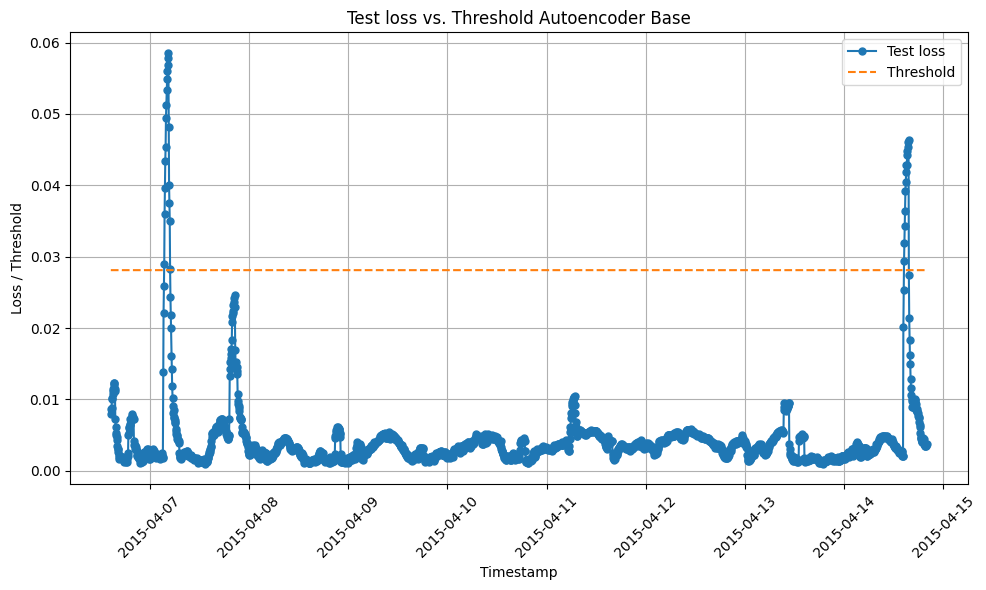

In [44]:
plt.figure(figsize=(10, 6))  
plt.plot(test_score_df['timestamp'], test_score_df['loss'], label='Test loss', marker='o', linestyle='-', markersize=5)
plt.plot(test_score_df['timestamp'], test_score_df['threshold'], label='Threshold', marker='', linestyle='--')
plt.title('Test loss vs. Threshold Autoencoder Base') 
plt.xlabel('Timestamp') 
plt.ylabel('Loss / Threshold') 
plt.legend() 
plt.grid(True) 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [45]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(32, 5)

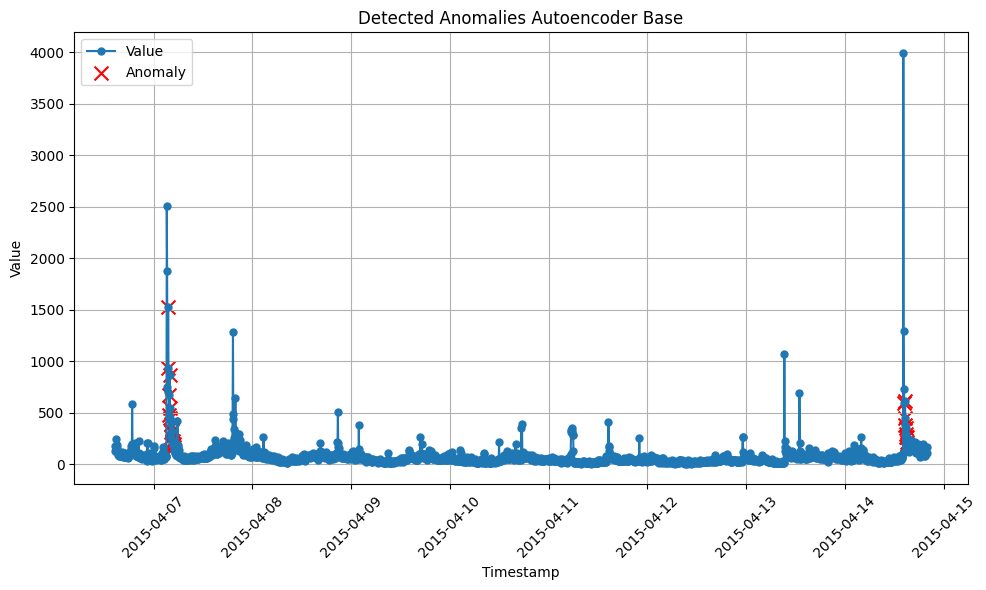

In [46]:
values_reshaped = test_score_df['value'].values.reshape(-1, 1)
values = scaler.inverse_transform(values_reshaped).flatten()
anomaly_values_reshaped = anomalies['value'].values.reshape(-1, 1)
anomaly_values = scaler.inverse_transform(anomaly_values_reshaped).flatten()

plt.figure(figsize=(10, 6))  
plt.plot(test_score_df['timestamp'], values, label='Value', marker='o', linestyle='-', markersize=5)
plt.scatter(anomalies['timestamp'], anomaly_values, color='red', label='Anomaly', marker='x', s=100)  
plt.title('Detected Anomalies Autoencoder Base')  
plt.xlabel('Timestamp')  
plt.ylabel('Value')  
plt.legend() 
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [47]:
weights_file_path = 'autoencoder_base.h5'
autoencoder_base.save_weights(weights_file_path)
print("Weights saved successfully.")

Weights saved successfully.


### Version 1

Increased Number of Layers

In [90]:
encoder_inputs = tf.keras.Input(shape=input_shape)
encoder = layers.Flatten()(encoder_inputs)
encoder = layers.Dense(16, activation='relu')(encoder)
encoder = layers.Dense(8, activation='relu')(encoder)
encoded = layers.Dense(4, activation='relu')(encoder)
encoded = layers.Dense(2, activation='relu')(encoder)
decoder = layers.Dense(4, activation='relu')(encoded)
decoder = layers.Dense(8, activation='relu')(decoder)
decoder = layers.Dense(16, activation='relu')(decoder)
decoder = layers.Dense(np.prod(input_shape), activation='sigmoid')(decoder)
decoded = layers.Reshape(input_shape)(decoder)
autoencoder_v1 = models.Model(encoder_inputs, decoded, name='autoencoder_v1')

In [91]:
autoencoder_v1.compile(optimizer='adam', loss='mse')
autoencoder_v1.summary()

Model: "autoencoder_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_25 (Dense)            (None, 2)                 18        
                                                                 
 dense_26 (Dense)            (None, 4)                 12        
                                                                 
 dense_27 (Dense)            (None, 8)              

In [92]:
history = autoencoder_v1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


348/348 [==============================] - 7s 9ms/step - loss: 0.0562 - val_loss: 0.0018
Epoch 2/10
348/348 [==============================] - 2s 7ms/step - loss: 5.0150e-04 - val_loss: 0.0017
Epoch 3/10
348/348 [==============================] - 3s 9ms/step - loss: 4.5911e-04 - val_loss: 0.0017
Epoch 4/10
348/348 [==============================] - 3s 9ms/step - loss: 4.5275e-04 - val_loss: 0.0017
Epoch 5/10
348/348 [==============================] - 3s 7ms/step - loss: 4.5026e-04 - val_loss: 0.0017
Epoch 6/10
348/348 [==============================] - 3s 7ms/step - loss: 4.4845e-04 - val_loss: 0.0017
Epoch 7/10
348/348 [==============================] - 3s 8ms/step - loss: 4.4683e-04 - val_loss: 0.0017
Epoch 8/10
348/348 [==============================] - 3s 8ms/step - loss: 4.4527e-04 - val_loss: 0.0017
Epoch 9/10
348/348 [==============================] - 2s 6ms/step - loss: 4.4409e-04 - val_loss: 0.0017
Epoch 10/10
348/348 [==============================] - 3s 9ms/step - loss: 4.42

In [93]:
print("Training Loss Autoencoder V1: ", history.history['loss'])
print("Validation Loss Autoencoder V1: ", history.history['val_loss'])

Training Loss Autoencoder V1:  [0.05618090555071831, 0.0005015008500777185, 0.00045910602784715593, 0.0004527549317572266, 0.0004502613446675241, 0.00044845364755019546, 0.0004468318657018244, 0.0004452742577996105, 0.00044408979010768235, 0.00044294341932982206]
Validation Loss Autoencoder V1:  [0.00180971494410187, 0.0017013580072671175, 0.0016911245184019208, 0.001688334159553051, 0.0016867073718458414, 0.0016849924577400088, 0.0016833181725814939, 0.001681812689639628, 0.0016802147729322314, 0.0016788305947557092]


In [94]:
test_loss = autoencoder_v1.evaluate(X_test, y_test)
print("Test Loss Autoencoder V1:", test_loss)

75/75 [==============================] - 0s 2ms/step - loss: 1.0596e-04
Test Loss Autoencoder V1: 0.00010596198990242556


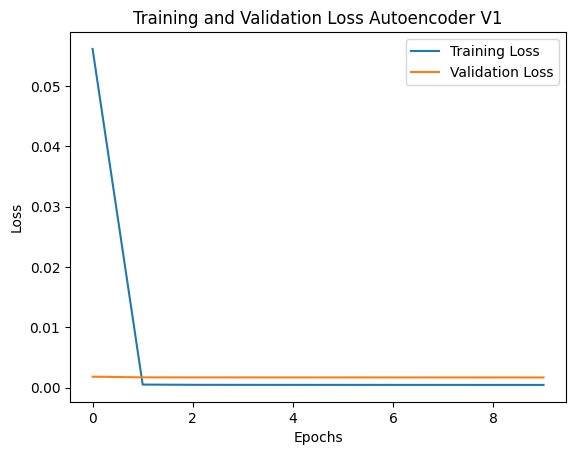

In [95]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Autoencoder V1')
plt.legend()
plt.show()


In [96]:
X_train_pred = autoencoder_v1.predict(X_train, verbose=0)
X_test_pred = autoencoder_v1.predict(X_test, verbose=0)

In [97]:
train_mse_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_mse_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [98]:
threshold = np.percentile(train_mse_loss, 98)

In [99]:
test_score_df = pd.DataFrame(test[sequence_size:])
test_score_df['loss'] = test_mse_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

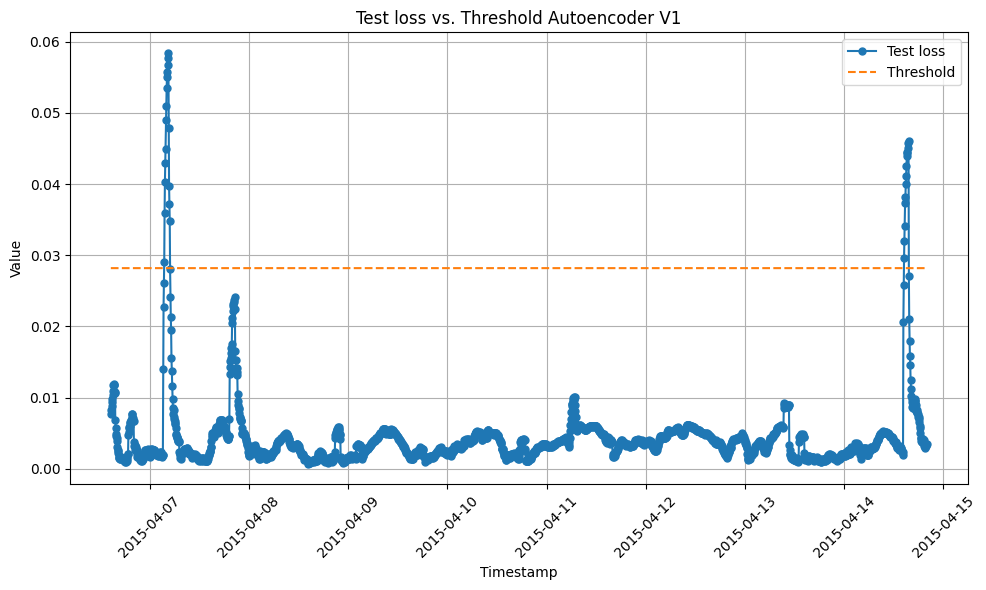

In [100]:
plt.figure(figsize=(10, 6))  
plt.plot(test_score_df['timestamp'], test_score_df['loss'], label='Test loss', linestyle='-', marker='o', markersize=5)
plt.plot(test_score_df['timestamp'], test_score_df['threshold'], label='Threshold', linestyle='--')
plt.title('Test loss vs. Threshold Autoencoder V1')  
plt.xlabel('Timestamp') 
plt.ylabel('Value')  
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

In [101]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(31, 5)

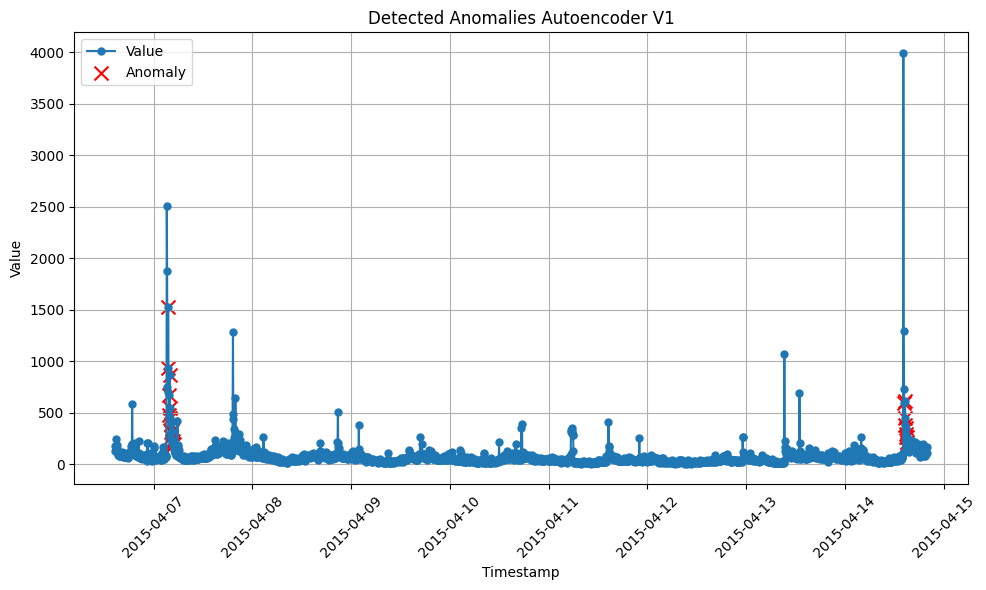

In [102]:
values_reshaped = test_score_df['value'].values.reshape(-1, 1)
values_inversed = scaler.inverse_transform(values_reshaped).flatten()
anomaly_values_reshaped = anomalies['value'].values.reshape(-1, 1)
anomaly_values_inversed = scaler.inverse_transform(anomaly_values_reshaped).flatten()

plt.figure(figsize=(10, 6))
plt.plot(test_score_df['timestamp'], values_inversed, label='Value', linestyle='-', marker='o', markersize=5)
plt.scatter(anomalies['timestamp'], anomaly_values_inversed, color='red', label='Anomaly', marker='x', s=100)
plt.title('Detected Anomalies Autoencoder V1') 
plt.xlabel('Timestamp') 
plt.ylabel('Value') 
plt.legend() 
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [103]:
weights_file_path = 'autoencoder_v1.h5'
autoencoder_v1.save_weights(weights_file_path)
print("Weights saved successfully.")

Weights saved successfully.


### Version 2

Let's change the activations,
- In the base version, We constantly used relu,
- Just want to include randomly and let's seehow the model behaves
- Activations used: Relu, tanh, sigmoid

In [104]:
encoder_inputs = tf.keras.Input(shape=input_shape)
encoder = layers.Flatten()(encoder_inputs)
encoder = layers.Dense(16, activation='relu')(encoder)
encoder = layers.Dense(8, activation='sigmoid')(encoder)
encoded = layers.Dense(4, activation='relu')(encoder)
encoded = layers.Dense(2, activation='tanh')(encoder)
decoder = layers.Dense(4, activation='relu')(encoded)
decoder = layers.Dense(8, activation='sigmoid')(decoder)
decoder = layers.Dense(16, activation='tanh')(decoder)
decoder = layers.Dense(np.prod(input_shape), activation='relu')(decoder)
decoded = layers.Reshape(input_shape)(decoder)
autoencoder_v2 = models.Model(encoder_inputs, decoded, name='autoencoder_v2')

In [105]:
autoencoder_v2.compile(optimizer='adam', loss='mse')
autoencoder_v2.summary()

Model: "autoencoder_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_30 (Dense)            (None, 16)                272       
                                                                 
 dense_31 (Dense)            (None, 8)                 136       
                                                                 
 dense_33 (Dense)            (None, 2)                 18        
                                                                 
 dense_34 (Dense)            (None, 4)                 12        
                                                                 
 dense_35 (Dense)            (None, 8)              

In [106]:
history = autoencoder_v2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


348/348 [==============================] - 8s 7ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 2/10
348/348 [==============================] - 2s 5ms/step - loss: 4.7036e-04 - val_loss: 0.0017
Epoch 3/10
348/348 [==============================] - 2s 5ms/step - loss: 4.7255e-04 - val_loss: 0.0017
Epoch 4/10
348/348 [==============================] - 2s 6ms/step - loss: 4.7367e-04 - val_loss: 0.0017
Epoch 5/10
348/348 [==============================] - 2s 6ms/step - loss: 4.7480e-04 - val_loss: 0.0017
Epoch 6/10
348/348 [==============================] - 2s 6ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 7/10
348/348 [==============================] - 2s 6ms/step - loss: 4.7528e-04 - val_loss: 0.0017
Epoch 8/10
348/348 [==============================] - 2s 7ms/step - loss: 4.7552e-04 - val_loss: 0.0017
Epoch 9/10
348/348 [==============================] - 2s 6ms/step - loss: 4.7533e-04 - val_loss: 0.0017
Epoch 10/10
348/348 [==============================] - 2s 5ms/step - loss: 4.75

In [107]:
print("Training Loss Autoencoder V2:", history.history['loss'])
print("Validation Loss Autoencoder V2:", history.history['val_loss'])

Training Loss Autoencoder V2: [0.002738452283665538, 0.0004703568120021373, 0.0004725480393972248, 0.00047366763465106487, 0.0004748025385197252, 0.0004755274567287415, 0.00047528211143799126, 0.0004755225090775639, 0.0004753349639941007, 0.00047552527394145727]
Validation Loss Autoencoder V2: [0.0016988468123599887, 0.0017032783944159746, 0.001709015341475606, 0.0017081121914088726, 0.001712295226752758, 0.0017122396966442466, 0.001711999299004674, 0.0017115864902734756, 0.0017121211858466268, 0.0017117023235186934]


In [108]:
test_loss = autoencoder_v2.evaluate(X_test, y_test)
print("Test Loss Autoencoder V2:", test_loss)

75/75 [==============================] - 0s 3ms/step - loss: 1.2878e-04
Test Loss Autoencoder V2: 0.00012878213601652533


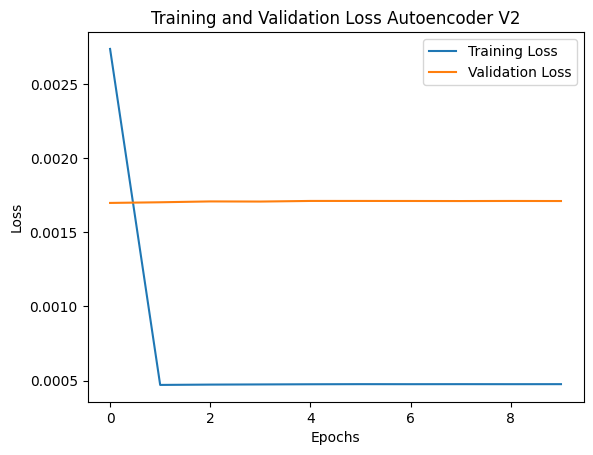

In [109]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Autoencoder V2')
plt.legend()
plt.show()


In [110]:
X_train_pred = autoencoder_v2.predict(X_train, verbose=0)
X_test_pred = autoencoder_v2.predict(X_test, verbose=0)

In [111]:
train_mse_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_mse_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [112]:
threshold = np.percentile(train_mse_loss, 95)

In [113]:
test_score_df = pd.DataFrame(test[sequence_size:])
test_score_df['loss'] = test_mse_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

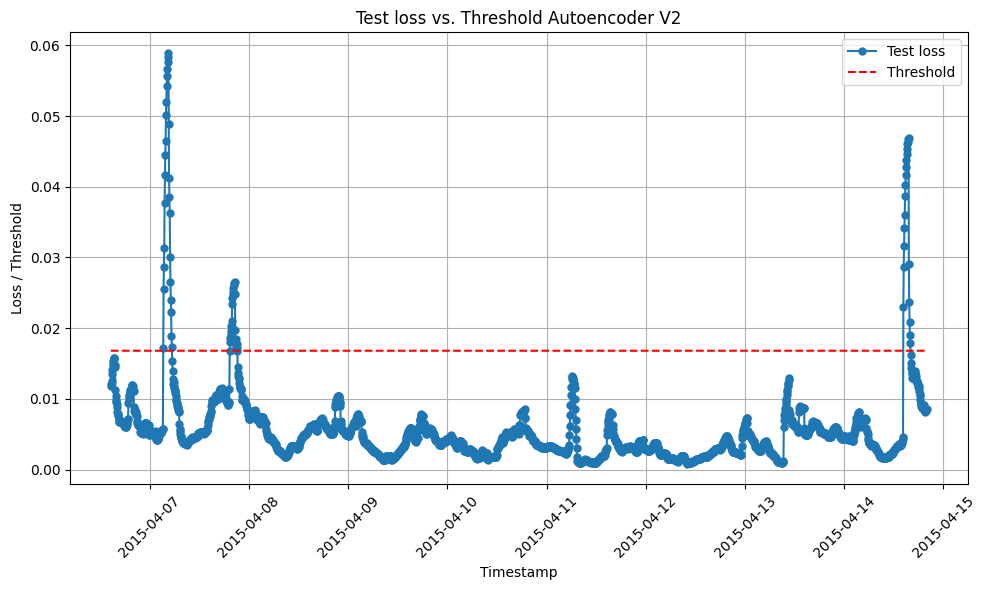

In [114]:
plt.figure(figsize=(10, 6))  
plt.plot(test_score_df['timestamp'], test_score_df['loss'], label='Test loss', linestyle='-', marker='o', markersize=5)
plt.plot(test_score_df['timestamp'], test_score_df['threshold'], label='Threshold', linestyle='--', color='r')
plt.title('Test loss vs. Threshold Autoencoder V2')  
plt.xlabel('Timestamp')  
plt.ylabel('Loss / Threshold')
plt.legend()  
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [115]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(69, 5)

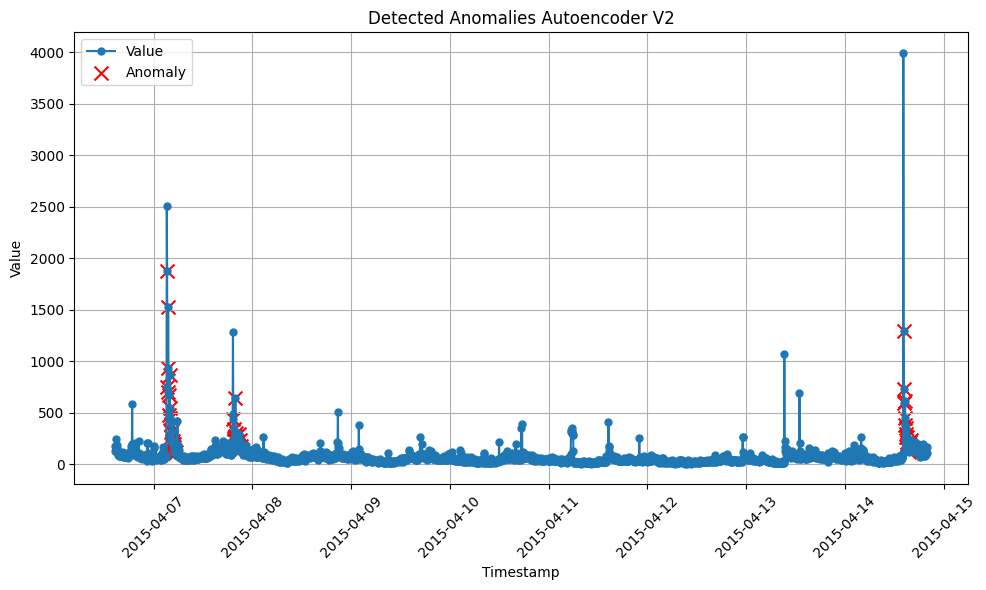

In [116]:
values_reshaped = test_score_df['value'].values.reshape(-1, 1)
values_inversed = scaler.inverse_transform(values_reshaped).flatten()
anomaly_values_reshaped = anomalies['value'].values.reshape(-1, 1)
anomaly_values_inversed = scaler.inverse_transform(anomaly_values_reshaped).flatten()

plt.figure(figsize=(10, 6))
plt.plot(test_score_df['timestamp'], values_inversed, label='Value', linestyle='-', marker='o', markersize=5)
plt.scatter(anomalies['timestamp'], anomaly_values_inversed, color='red', label='Anomaly', marker='x', s=100)
plt.title('Detected Anomalies Autoencoder V2')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [117]:
weights_file_path = 'autoencoder_v2.h5'
autoencoder_v2.save_weights(weights_file_path)
print("Weights saved successfully.")


Weights saved successfully.


### Version 3

As this is a time series data, LSTM could be useful, so let's evaluate

In [76]:
encoder_inputs = tf.keras.Input(shape=input_shape)
encoder = layers.LSTM(16, return_sequences=True)(encoder_inputs)
encoder = layers.LSTM(8, return_sequences=True)(encoder)
encoded = layers.LSTM(4, return_sequences=False)(encoder)
encoded = layers.RepeatVector(input_shape[0])(encoded)
decoder = layers.LSTM(8, return_sequences=True)(encoded)
decoder = layers.LSTM(16, return_sequences=True)(decoder)
decoder = layers.TimeDistributed(layers.Dense(1, activation='relu'))(decoder)
autoencoder_v3 = models.Model(encoder_inputs, decoder, name='autoencoder_v3')

In [77]:
autoencoder_v3.compile(optimizer='adam', loss='mse')
autoencoder_v3.summary()

Model: "autoencoder_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 16, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 16, 8)             800       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 repeat_vector (RepeatVecto  (None, 16, 4)             0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 16, 8)             416       
                                                    

In [78]:
history = autoencoder_v3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


348/348 [==============================] - 56s 80ms/step - loss: 4.7549e-04 - val_loss: 0.0017
Epoch 2/10
348/348 [==============================] - 21s 61ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 3/10
348/348 [==============================] - 22s 63ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 4/10
348/348 [==============================] - 23s 65ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 5/10
348/348 [==============================] - 22s 62ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 6/10
348/348 [==============================] - 21s 60ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 7/10
348/348 [==============================] - 21s 60ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 8/10
348/348 [==============================] - 22s 63ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 9/10
348/348 [==============================] - 22s 64ms/step - loss: 4.7553e-04 - val_loss: 0.0017
Epoch 10/10
348/348 [==============================] - 22

In [79]:
print("Training Loss Autoencoder V3:", history.history['loss'])
print("Validation Loss Autoencoder V3:", history.history['val_loss'])

Training Loss Autoencoder V3: [0.00047548545990139246, 0.00047552899923175573, 0.00047552926116622984, 0.0004755289410240948, 0.0004755290283355862, 0.0004755287372972816, 0.00047552899923175573, 0.00047552891192026436, 0.0004755290283355862, 0.0004755290283355862]
Validation Loss Autoencoder V3: [0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396, 0.0017123399302363396]


In [80]:
test_loss = autoencoder_v3.evaluate(X_test, y_test)
print("Test Loss Autoencoder V3:", test_loss)

43/75 [================>.............] - ETA: 0s - loss: 1.1869e-04

75/75 [==============================] - 2s 20ms/step - loss: 1.2878e-04
Test Loss Autoencoder V3: 0.00012878213601652533


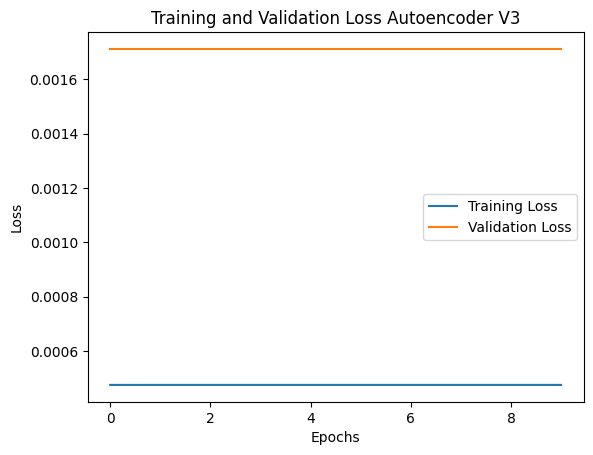

In [81]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Autoencoder V3')
plt.legend()
plt.show()


In [82]:
X_train_pred = autoencoder_v3.predict(X_train, verbose=0)
X_test_pred = autoencoder_v3.predict(X_test, verbose=0)

In [83]:
train_mse_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_mse_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [84]:
threshold = np.percentile(train_mse_loss, 95)

In [85]:
test_score_df = pd.DataFrame(test[sequence_size:])
test_score_df['loss'] = test_mse_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

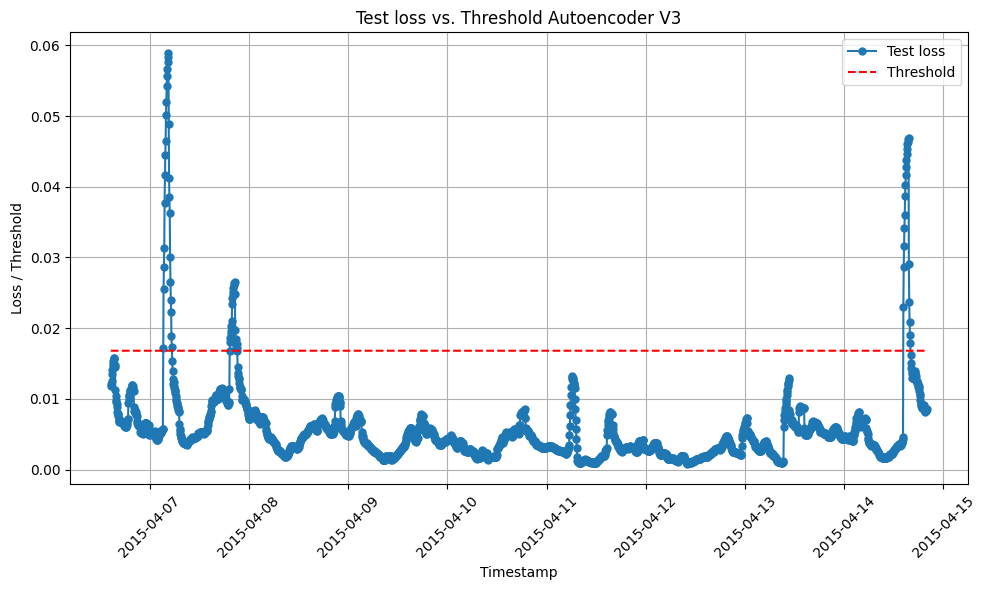

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(test_score_df['timestamp'], test_score_df['loss'], label='Test loss', linestyle='-', marker='o', markersize=5)
plt.plot(test_score_df['timestamp'], test_score_df['threshold'], label='Threshold', linestyle='--', color='r')
plt.title('Test loss vs. Threshold Autoencoder V3')
plt.xlabel('Timestamp')
plt.ylabel('Loss / Threshold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [87]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(69, 5)

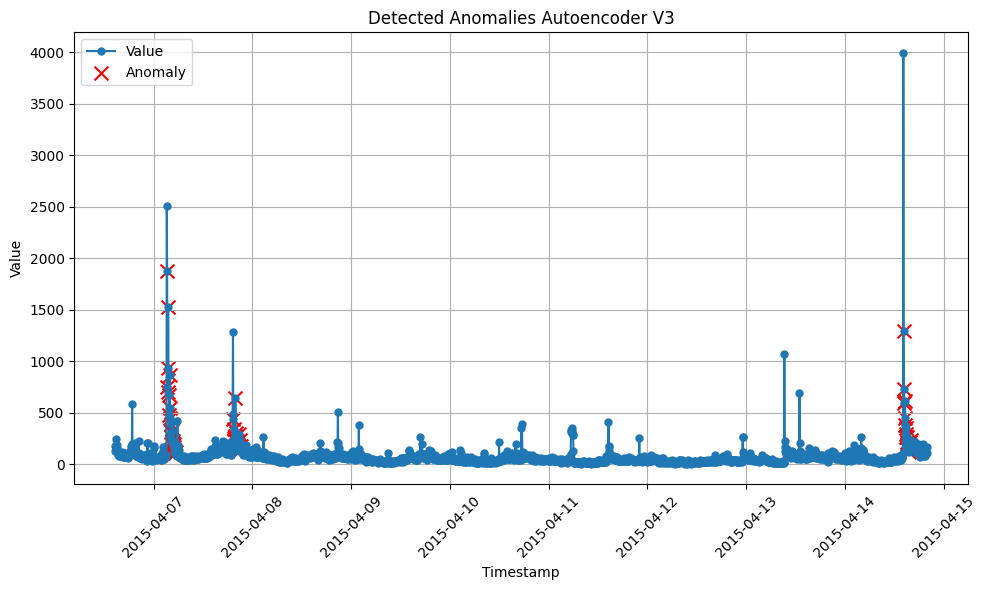

In [88]:
values_reshaped = test_score_df['value'].values.reshape(-1, 1)
values_inversed = scaler.inverse_transform(values_reshaped).flatten()
anomaly_values_reshaped = anomalies['value'].values.reshape(-1, 1)
anomaly_values_inversed = scaler.inverse_transform(anomaly_values_reshaped).flatten()

plt.figure(figsize=(10, 6))
plt.plot(test_score_df['timestamp'], values_inversed, label='Value', linestyle='-', marker='o', markersize=5)
plt.scatter(anomalies['timestamp'], anomaly_values_inversed, color='red', label='Anomaly', marker='x', s=100)
plt.title('Detected Anomalies Autoencoder V3')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
weights_file_path = 'autoencoder_v3.h5'
autoencoder_v3.save_weights(weights_file_path)
print("Weights saved successfully.")

Weights saved successfully.
